# Embedding hosts as distributions on point clouds of process instances

An interesting insight on representing objects with vectors is that they enable _hierarchical_ vector space embeddings.
Indeed, if one has a hierarchy of objects containing each other,
then a vector representation of the innermost objects can be lifted back up through a sequence of Wasserstein embeddings of the container layers.

Concretely, we have process instances, attached to command lines.
On the one hand, command lines (and thus process instances) _contain_ a set of tokens.
On the other hand, processes run on hosts at a specific time;
said differently, hosts, over a certain time interval, _contain_ a set of process instances.
So, since we have a vector space embedding of process instances (command lines really),
we can get a vector representation of hosts as distributions on a point cloud of process instances.
<a id="interpretation"></a>
Thus hosts, in a time interval, would accrete into clusters when they run similar process workloads.

---

Goals of this notebook:

1. Compute a vector representation of hosts in a sequence of time intervals.
2. Appraise these vectors in a flat data map.
3. Derive a naïve visualization of the behaviour of a single host over time.

---

**Attention**: results from [notebook 2](Command%20lines%20-%20Wasserstein%20embedding.ipynb) are required for what follows, so run that notebook first.

In [1]:
import datamapplot as dmp
from fast_hdbscan import HDBSCAN
import glasbey
from IPython.display import Video
from matplotlib import colormaps
from matplotlib.animation import FuncAnimation
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal
import scipy.sparse
from tqdm.auto import trange, tqdm
import umap
import vectorizers as vz
import vectorizers.transformers as vzt

Gather our processes.

In [2]:
processes = pd.read_parquet("process_filtered.parquet")
processes

,pid_hash,parent_pid_hash,timestamp,hostname,name,cmdline,ptree
0,3F8784056EB55BB295DCAB8C9344254A,BA7EC59E059F8E7B9F75D3BD0D3E85FE,2023-11-05 00:00:00.314092-07:00,ACME-HH-YIM,wsqmcons.exe,"""c:\windows\system32\wsqmcons.exe""",=wsqmcons.exe->svchost.exe->services.exe->wini...
1,B64CB859912B447E83D8C8E619ABCF93,50F07B711DB04C89FF3922CD15C2647B,2023-11-05 00:00:00.377725-07:00,ACME-HH-UWI,wsqmcons.exe,"""c:\windows\system32\wsqmcons.exe""",=wsqmcons.exe->svchost.exe->services.exe->wini...
2,921D6E35B58C5CA571A55D96C16A5D6A,981581F0C573975A7D576645C5B731F0,2023-11-05 00:00:00.436069-07:00,ACME-HH-HGC,wsqmcons.exe,"""c:\windows\system32\wsqmcons.exe""",=wsqmcons.exe->svchost.exe->services.exe->wini...
3,22E2B0D56B1F636B09CBDC86CCDBBD97,483B551ED4FD3BF742CBBD9B343E8117,2023-11-05 00:00:00.586099-07:00,ACME-WS-AZU,wsqmcons.exe,"""c:\windows\system32\wsqmcons.exe""",=wsqmcons.exe->svchost.exe->services.exe->wini...
4,F1F1B598005B90EB45FBF77E74DDFCB8,803022DFF3341FF443B9D49E08D82558,2023-11-05 00:00:00.731733-07:00,ACME-HH-AKA,wsqmcons.exe,"""c:\windows\system32\wsqmcons.exe""",=wsqmcons.exe->svchost.exe->services.exe->wini...
...,...,...,...,...,...,...,...
136701,11D2905584ADEBDB004263B08D3706A1,5B1453B37F079EC6AA910E820C5B6BF1,2023-11-20 15:54:14.616846-08:00,ACME-HH-IKA,usoclient.exe,"""c:\windows\system32\usoclient.exe"" startscan",=usoclient.exe->svchost.exe->services.exe->win...
136702,D8DC51881EDB5C6F7D6239E3DE1A5D93,E283B625D417A1C9584B2D6C9D0C364F,2023-11-20 15:54:14.638486-08:00,ACME-HH-IKA,mousocoreworker.exe,"""c:\windows\system32\mousocoreworker.exe"" -emb...",=mousocoreworker.exe->svchost.exe->services.ex...
136703,521490D4B45E5BDC4BD2CA7081BC06A7,6A37E544F4D9E91016071993B3DC4103,2023-11-20 15:55:23.333011-08:00,ACME-HH-AZH,usoclient.exe,"""c:\windows\system32\usoclient.exe"" startscan",=usoclient.exe->svchost.exe->services.exe->win...
136704,D2211D916C3414FDFBD2663BB9051C84,2C2DB3363D7539099C7869C6BFEEED6B,2023-11-20 15:55:23.349693-08:00,ACME-HH-AZH,mousocoreworker.exe,"""c:\windows\system32\mousocoreworker.exe"" -emb...",=mousocoreworker.exe->svchost.exe->services.ex...


Get the better command line vectors.

In [3]:
cmdlines_vec = np.load("cmdlines_wasserstein.npz")["cmdlines"]
cmdlines_vec.shape

(30994, 128)

So our command line vectors were derived with _uniqued_ command lines.
We want to take into account _all_ process instances here, so let's tie the index to each command line vector back to the process instance record.

In [4]:
with np.load("cmdlines_unique.npz") as store_cmdlines_unique:
    i_unique = store_cmdlines_unique["i_unique"]
    i_deunique = store_cmdlines_unique["i_deunique"]
processes_indexed = processes[["name", "pid_hash", "hostname"]].copy()
processes_indexed["timestamp"] = processes["timestamp"].dt.tz_convert("-0500")
processes_indexed["index_vec"] = i_deunique
processes_indexed

,name,pid_hash,hostname,timestamp,index_vec
0,wsqmcons.exe,3F8784056EB55BB295DCAB8C9344254A,ACME-HH-YIM,2023-11-05 02:00:00.314092-05:00,30162
1,wsqmcons.exe,B64CB859912B447E83D8C8E619ABCF93,ACME-HH-UWI,2023-11-05 02:00:00.377725-05:00,30162
2,wsqmcons.exe,921D6E35B58C5CA571A55D96C16A5D6A,ACME-HH-HGC,2023-11-05 02:00:00.436069-05:00,30162
3,wsqmcons.exe,22E2B0D56B1F636B09CBDC86CCDBBD97,ACME-WS-AZU,2023-11-05 02:00:00.586099-05:00,30162
4,wsqmcons.exe,F1F1B598005B90EB45FBF77E74DDFCB8,ACME-HH-AKA,2023-11-05 02:00:00.731733-05:00,30162
...,...,...,...,...,...
136701,usoclient.exe,11D2905584ADEBDB004263B08D3706A1,ACME-HH-IKA,2023-11-20 18:54:14.616846-05:00,30029
136702,mousocoreworker.exe,D8DC51881EDB5C6F7D6239E3DE1A5D93,ACME-HH-IKA,2023-11-20 18:54:14.638486-05:00,28614
136703,usoclient.exe,521490D4B45E5BDC4BD2CA7081BC06A7,ACME-HH-AZH,2023-11-20 18:55:23.333011-05:00,30029
136704,mousocoreworker.exe,D2211D916C3414FDFBD2663BB9051C84,ACME-HH-AZH,2023-11-20 18:55:23.349693-05:00,28614


And now, count instances of each command line by host and by time interval.
First group process instances by host,
then `resample` the process instance timestamps in 3-hour bins.
We also ensure to reject all process instances that might formally be outside of the data capture period &mdash;
we seem to have some instances timestamped prior to November 5 2023, midnight EST.
The baroque pandasism that follows handles that.

In [5]:
%%time
processes_x_host_time = pd.concat([
    (
        group
        .resample(pd.Timedelta(hours=3), on="timestamp", origin=pd.Timestamp("2023-11-05", tz="-0500"))
        .agg({
            "index_vec": lambda x: list(pd.Series(x).value_counts().items()) or np.nan,
            "pid_hash": lambda x: list(x) or np.nan
        })
        .assign(hostname=hostname)
        .reset_index()
    )
    for hostname, group in processes_indexed.groupby("hostname")
]).dropna().sort_values(["timestamp", "hostname"]).reset_index(drop=True)
processes_x_host_time

CPU times: user 221 ms, sys: 4.04 ms, total: 225 ms
Wall time: 225 ms


,timestamp,index_vec,pid_hash,hostname
0,2023-11-05 00:00:00-05:00,"[(28614, 1), (29460, 1), (26509, 1), (29469, 1...","[56CDA2FBD2E880CEE9520F06743C04EA, AD02784D740...",ACME-DC1
1,2023-11-05 00:00:00-05:00,"[(30162, 1), (28614, 1), (29476, 1), (29480, 1...","[F1F1B598005B90EB45FBF77E74DDFCB8, 72DFD720300...",ACME-HH-AKA
2,2023-11-05 00:00:00-05:00,"[(30162, 1), (29476, 1), (29446, 1), (28614, 1...","[696BA71E6CF6879C2C91E204C3C137FB, 32C0E6E988D...",ACME-HH-AXF
3,2023-11-05 00:00:00-05:00,"[(30162, 1), (29476, 1), (29446, 1), (6953, 1)...","[62D054718CCEB3E1980225F8870D7A24, 09FC9FB7B86...",ACME-HH-AZH
4,2023-11-05 00:00:00-05:00,"[(29469, 2), (29413, 2), (30162, 1), (29476, 1...","[6CFC82468479CA2C930C395DEB7E3900, A2779663E7F...",ACME-HH-CCF
...,...,...,...,...
2544,2023-11-20 15:00:00-05:00,"[(26509, 6), (29460, 6), (28098, 3), (29446, 3...","[9B184238C4B3508C44A0889548CE38EA, 8C4F00E4E8B...",ACME-HH-IQS
2545,2023-11-20 18:00:00-05:00,"[(3110, 1), (6222, 1), (29460, 1), (26509, 1),...","[8DDE6F47DB90619F86BD14A16F98CEE2, 9BD3697DCEA...",ACME-DC1
2546,2023-11-20 18:00:00-05:00,"[(28614, 2), (28900, 1), (28098, 1), (29451, 1...","[5BB26EE4E63E3CE44E7FFAB5A0E6E321, AE736B4B16B...",ACME-HH-AZH
2547,2023-11-20 18:00:00-05:00,"[(28614, 2), (28900, 1), (28098, 1), (29451, 1...","[2B81182F7C23BE3D4A934313D3FCB52B, A15DA5AF705...",ACME-HH-IKA


Ok, so we have the command line vectors, what we are missing are the weighted distributions.
Each row of `processes_x_host_time` above represents a (host, time interval) couple &mdash; let's call these _host-times_.
The `index_vec` column contains a list of (command line index, count) for each of these host-times.
Since host-times are expressed over the vocabulary of (vector-represented) command lines,
these are essentially the elements we need to build the count matrix.
If we [explode](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.explode.html) the `index_vec` column,
each row of the resulting data frame contains a triple of the form

```
(row identifier, column identifier, count)
```

A list of such triples suffices to build up the count matrix in a [sparse COO format](https://matteding.github.io/2019/04/25/sparse-matrices/#coordinate-matrix).
We have the `vectorizers.EdgeListVectorizer` to render this.
Notice that we are forcing the column space to match the full set of command line indices.
This is because otherwise, `EdgeListVectorizer` realizes that some command line indices are not used between minimum and maximum observed indices, and discards the corresponding columns.
Forcing the existence of these empty columns makes it easier to match counts back to our vectors.

In [6]:
%%time
vz_tc = vz.EdgeListVectorizer(column_label_dictionary={i: i for i in range(len(cmdlines_vec))}).fit([
    ((t.timestamp, t.hostname), *t.index_vec)
    for t in processes_x_host_time.explode("index_vec").dropna().itertuples(index=False)
])
pxht_tc = vz_tc._train_matrix.tocsr()
pxht_tc

CPU times: user 14.6 s, sys: 46.9 ms, total: 14.6 s
Wall time: 14.6 s


<2549x30994 sparse matrix of type '<class 'numpy.float64'>'
	with 74600 stored elements in Compressed Sparse Row format>

Modulate counts by information contribution.

In [7]:
%%time
pxht_iwt = vzt.InformationWeightTransformer().fit_transform(pxht_tc)
pxht_iwt

CPU times: user 337 ms, sys: 12.2 ms, total: 350 ms
Wall time: 351 ms


<2549x30994 sparse matrix of type '<class 'numpy.float64'>'
	with 74600 stored elements in Compressed Sparse Row format>

Now we have what we need to vectorize the host-times.

In [8]:
%%time
pxht_vec = vz.WassersteinVectorizer().fit_transform(pxht_iwt, vectors=cmdlines_vec)
pxht_vec

CPU times: user 1min 20s, sys: 8.25 s, total: 1min 29s
Wall time: 17.8 s


array([[ 4.65558449e+00, -5.58356032e+00, -1.12563740e+00, ...,
        -7.68703067e-03, -4.45136702e-01, -1.57195824e-01],
       [ 2.32172237e+00, -1.87163266e+00, -6.17892512e-02, ...,
         1.32848456e-01, -6.85284632e-02,  6.81173192e-01],
       [ 4.44249311e+00, -2.32975679e+00, -4.78578250e-01, ...,
        -7.46442906e-02,  5.27855187e-01, -4.55018328e-01],
       ...,
       [ 5.57285201e+00, -4.92374956e+00,  4.59681744e-02, ...,
         1.07394110e-01,  1.15181618e-01, -4.20507171e-01],
       [ 6.96246260e+00, -3.61103338e+00, -6.53831942e-01, ...,
         1.41542502e-01,  5.01234611e-01, -6.76426525e-01],
       [ 5.60750526e+00, -4.76178381e+00, -2.83156726e-01, ...,
        -3.18677832e-03,  2.22560767e-01, -2.43053562e-01]])

Compress these vectors into a data map.

In [9]:
%%time
pxht_dmap = umap.UMAP(metric="cosine", verbose=True).fit_transform(pxht_vec)

UMAP(angular_rp_forest=True, metric='cosine', verbose=True)
Tue Jul  9 21:53:14 2024 Construct fuzzy simplicial set
Tue Jul  9 21:53:16 2024 Finding Nearest Neighbors
Tue Jul  9 21:53:17 2024 Finished Nearest Neighbor Search
Tue Jul  9 21:53:18 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue Jul  9 21:53:22 2024 Finished embedding
CPU times: user 28.2 s, sys: 2.64 s, total: 30.9 s
Wall time: 8.43 s


As I said [above](#interpretation),
points in the data map get close together when the corresponding host-times are characterized by similar ~processes~ command lines.
So it would be nice to annotate the clusters of the data map so we may understand the commands or programs that make them up.
I think of it as _descriptions of workloads._
Unfortunately, there is not much room in a data map to describe the multiple programs that make up a workload.
Let's try compressing that to the _3 most important processes_, characterized by their name.

How can we measure the importance of a program to a workload?
The information-reweighted count matrix can answer this question.
The information weight transformer replaces raw counts with _numbers of bits of information_ contributed by each component that characterizes a bag.
One takes the host-times that make up a cluster, sums their corresponding rows of the IWT matrix.
Then take each such sum in turn, in decreasing order:
any large number of bits corresponds to a command line that is significant for characterizing this host-time.
Then find all other non-zero-bits process instances of the same name as this one high-information command line
(within the same cluster),
combine them together.
If there are enough bits between them all, then this program truly makes this cluster accrete together, and we use it to annotate the cluster.
We take as much as 3 such program names to form the label.

In [10]:
clusters = HDBSCAN(cluster_selection_method="leaf").fit_predict(pxht_dmap)
num_clusters = np.unique(clusters).shape[0] - 1
num_clusters

162

In [11]:
labels_cluster = {}
last_bits = 0
for cluster in trange(num_clusters):
    iwt_cluster = np.array(pxht_iwt[clusters == cluster, :].todense())
    bits_cluster = np.sum(iwt_cluster, axis=0)
    processes_cluster = (
        processes_indexed
        .merge(
            processes_x_host_time["pid_hash"].iloc[clusters == cluster].explode(),
            on="pid_hash",
            how="inner"
        )
        .merge(
            pd.Series(bits_cluster, name="bits"),
            how="inner",
            left_on="index_vec",
            right_index=True
        )
    )

    i_important = np.argsort(-bits_cluster)
    names = {}
    for i in i_important:
        if bits_cluster[i] < 1e-6:
            break
        processes_cmdline = processes_cluster.loc[processes_cluster["index_vec"] == i]
        assert not processes_cmdline.empty
        name = processes_cmdline.iloc[0]["name"]
        if name not in names:
            processes_same_name = processes_cluster.loc[processes_cluster["name"] == name]
            bits = processes_same_name["bits"].mean()
            if bits >= 1.:
                names[name] = bits
    if names:
        names_sorted = sorted(list(names.items()), key=lambda p: p[1], reverse=True)
        _, bits_max = names_sorted[0]
        names_filtered = [(name, bits) for name, bits in names_sorted if bits >= bits_max / 10.]
        labels_cluster[cluster] = "\n".join(
            f"{name} {bits:.1f}"
            for name, bits in names_filtered[:3]
        )
    else:
        labels_cluster[cluster] = "Unlabelled"
pd.DataFrame(labels_cluster.values(), columns=["labels_cluster"], index=labels_cluster.keys())

  0%|          | 0/162 [00:00<?, ?it/s]

,labels_cluster
0,upfc.exe 2.9\nsihclient.exe 2.9\nsc.exe 2.1
1,microsoftedge_x64_119.0.2151.72_119.0.2151.58....
2,microsoftedge_x64_119.0.2151.44_118.0.2088.76....
3,upfc.exe 2.8\ndismhost.exe 2.7\ncleanmgr.exe 2.6
4,googleupdate.exe 9.0\nsihclient.exe 2.7\nupfc....
...,...
157,ngen.exe 2.3\nsearchprotocolhost.exe 2.2\ndism...
158,dismhost.exe 2.1\nmsedge.exe 2.0\ncompattelrun...
159,dismhost.exe 2.1\nmsedge.exe 2.1\ndevicecensus...
160,msedge.exe 2.2\nbackgroundtaskhost.exe 1.2


Propagate these cluster labels to the points.

In [12]:
labels = [labels_cluster.get(c, "") or "Unlabelled" for c in clusters]
pd.Series(labels)

0                         svchost.exe 3.4\nmsedge.exe 2.7
1                                        dsregcmd.exe 6.5
2       speechmodeldownload.exe 3.5\nmusnotification.e...
3                              backgroundtaskhost.exe 1.2
4       speechmodeldownload.exe 1.4\nmusnotification.e...
                              ...                        
2544    mpcmdrun.exe 2.8\nbackgroundtaskhost.exe 2.6\n...
2545    svchost.exe 3.2\nmsedge.exe 2.7\nmergehelper.e...
2546                                           sc.exe 3.0
2547                                           Unlabelled
2548    sc.exe 1.8\nbackgroundtaskhost.exe 1.3\nrundll...
Length: 2549, dtype: object

We get to identify host-times quite simply: with hostname and, um, time.

In [13]:
hover_text = processes_x_host_time["hostname"] + ", " + processes_x_host_time.timestamp.dt.strftime("%b %d, %H:%M")
hover_text

0          ACME-DC1, Nov 05, 00:00
1       ACME-HH-AKA, Nov 05, 00:00
2       ACME-HH-AXF, Nov 05, 00:00
3       ACME-HH-AZH, Nov 05, 00:00
4       ACME-HH-CCF, Nov 05, 00:00
                   ...            
2544    ACME-HH-IQS, Nov 20, 15:00
2545       ACME-DC1, Nov 20, 18:00
2546    ACME-HH-AZH, Nov 20, 18:00
2547    ACME-HH-IKA, Nov 20, 18:00
2548    ACME-HH-IQS, Nov 20, 18:00
Length: 2549, dtype: object

So far, we have let labeling determine the color of the points.
Since time plays an important role here, let's use point color to track it,
using a continuous color map.

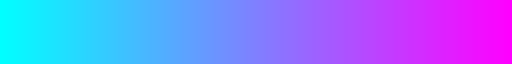

In [14]:
cmap = colormaps["cool"]
cmap

So cool points correspond to early host-times, and hot ones, to late host-times.

In [15]:
ts_min, ts_max = processes_x_host_time["timestamp"].agg(["min", "max"])
delta = ts_max - ts_min
dmp.create_interactive_plot(
    pxht_dmap,
    labels,
    hover_text=hover_text,
    title="Hosts over time",
    sub_title="as distributions over a cloud of command line vectors",
    darkmode=True,
    color_label_text=False,
    marker_color_array=[cmap((ts - ts_min) / delta) for ts in processes_x_host_time["timestamp"]],
    enable_search=True
)

<InteractiveFigure width=100% height=800>

In [16]:
processes_x_host_time["hostname"].unique()

array(['ACME-DC1', 'ACME-HH-AKA', 'ACME-HH-AXF', 'ACME-HH-AZH',
       'ACME-HH-CCF', 'ACME-HH-CLR', 'ACME-HH-DFN', 'ACME-HH-EAY',
       'ACME-HH-HGC', 'ACME-HH-IQS', 'ACME-HH-MBY', 'ACME-HH-OLY',
       'ACME-HH-TTW', 'ACME-HH-UWI', 'ACME-HH-YIM', 'ACME-WS-AZU',
       'ACME-WS-NUQ', 'ACME-WS-PLU', 'ACME-WS-PRV', 'ACME-WS-UVF',
       'ACME-HH-ATV', 'ACME-HH-IKA', 'ACME-HH-KKN', 'ACME-HH-TON',
       'ACME-HH-BVW'], dtype=object)

At a glance, we see that no software workload is time specific:
all regions of the space host points running the whole color range.
This visualization makes it difficult to track how hosts cover the space;
a quick look around hovering over points suggest that most hosts
carry workloads all over the space, given time.
None of these hosts manifests any specialized behaviour:
they just zoom around the space over time.
This is surprising at first blush, given that at least one of these hosts,
`ACME-DC1`, is the Domain Controller of the network &mdash; a rather specific role.
The generic shape of its behaviour likely stems from the network being small and barely used compared to a regular enterprise network.
As such, the DC services a handful of authentication queries per day,
making it look just like any other workstation on the network.